---
# Trabalho 1 - Tópicos Especiais em Matemática Aplicada

**Alunos/Matricula:** João V. Farias & Renan V. Guedes / 221022604 & 221031363

**Arquitetura Usada:** Encoder-Decoder

**Dataset Link:** V1: [D-Talk](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatefr_to_pt) from TensorFlow.Datasets

---

### **Projeto para traduzir mensagens do Francês para o Portugues**  

Neste projeto, vamos explorar e comparar três arquiteturas de redes neurais para tradução automática do francês para o português, usando o *dataset* TED Talks do *Open Translation Project*. A ideia é testar modelos do tipo **Encoder-Decoder**, analisando suas diferenças e impacto na qualidade da tradução.  

Os três modelos que vamos treinar são:  

1. **LSTM (Long Short-Term Memory)**  
   - Um modelo básico de rede recorrente bidirecional. O **Encoder** processa a frase em francês e gera um contexto, enquanto o **Decoder** usa esse contexto para formar a tradução em português.  
   - A principal vantagem desse modelo é sua capacidade de lidar com dependências de longo prazo nas sequências.  

2. **LSTM com Mecanismos de Atenção**  
   - Uma versão aprimorada do modelo anterior, adicionando camadas de atenção (produto escalar, Bahdanau e Luong).  
   - A atenção ajuda o modelo a "olhar" para partes específicas da frase de entrada enquanto traduz, melhorando a coerência e precisão.  

3. **Transformers**  
   - Uma abordagem mais moderna, baseada em **autoatenção**, eliminando o uso de redes recorrentes.  
   - Trabalha com processamento paralelo, usando *Multi-Head Attention* e *Positional Encoding* para entender relações entre palavras, mesmo quando estão distantes na frase.  

**Como vamos testar os modelos?**  
- **Dataset**: Vamos usar cerca de 52.000 pares de frases (francês-português) para treinar, além de 1.200 para validação e 1.800 para teste.  
- **Pré-processamento**: Faremos a tokenização com *SubwordTextEncoder* para reduzir palavras fora do vocabulário (*out-of-vocabulary* – OOV).  
- **Treinamento**: Otimização com Adam, acompanhando a perda (*loss*) e a acurácia durante o processo.  
- **Avaliação**: Vamos comparar os resultados usando a métrica BLEU e analisar exemplos práticos das traduções.  

**O que esperamos encontrar?**  
- Nosso objetivo é entender qual desses modelos tem o melhor equilíbrio entre qualidade de tradução e eficiência computacional.  
- É provável que os Transformers tenham um desempenho superior, já que conseguem processar frases de forma mais eficiente, enquanto os modelos com LSTM e atenção devem mostrar um avanço significativo sobre a versão básica de LSTM.  

No fim das contas, essa análise pode ajudar a compreender melhor como diferentes abordagens de deep learning se saem em tarefas de tradução, trazendo insights úteis para aplicações reais em NLP.

---

## 📚 Importando as bibliotecas necessárias

In [1]:
# Primeiro, vamos importar todas as bibliotecas que vamos precisar ao longo do Projeto
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Para processamento de texto
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Componentes do Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

# Para visualização dos resultados
from sklearn.metrics import confusion_matrix

tf.config.optimizer.set_jit(True)  # Ativa o XLA JIT compilation
tf.keras.mixed_precision.set_global_policy('mixed_float16') # Força o TensorFlow a usar precisão mista

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## 🔍 Carregando e Preparando os Dados

In [36]:
#Agora vamos carregar nosso dataset de tradução
examples, metadata = tfds.load('ted_hrlr_translate/fr_to_pt', with_info=True,
                             as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# Função para preprocessar o texto
def preprocess_text(text):
    # Adiciona espaços entre pontuação
    text = tf.strings.regex_replace(text, r"([?.!,¿])", r" \1 ")
    # Remove caracteres especiais
    text = tf.strings.regex_replace(text, r'[" "]+', " ")
    # Remove espaços extras
    text = tf.strings.strip(text)
    # Adiciona tokens de início e fim
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

# Vamos processar nossos dados
def prepare_dataset(fr, pt):
    fr = preprocess_text(fr)
    pt = preprocess_text(pt)
    return fr, pt

# Aplicando o preprocessamento
train_dataset = train_examples.map(prepare_dataset)
val_dataset = val_examples.map(prepare_dataset)

print("\n Dataset carregado e preprocessado com sucesso! 🎉")


 Dataset carregado e preprocessado com sucesso! 🎉


## 🛠️ Configurando os Tokenizers

In [37]:
# 🛠️ Configurando os Tokenizers (versão otimizada)
MAX_SAMPLES = 50000  # Limite de amostras para processamento mais rápido

# Coletando os textos para treinamento dos tokenizers
fr_texts = []
pt_texts = []
for fr, pt in train_dataset.take(MAX_SAMPLES):
    pt_texts.append(pt.numpy().decode('utf-8'))
    fr_texts.append(fr.numpy().decode('utf-8'))

In [38]:
#
tokenizer_fr = Tokenizer(filters='', oov_token='[OOV]')
tokenizer_fr.fit_on_texts(fr_texts)
input_vocab_size = len(tokenizer_fr.word_index) + 1

tokenizer_pt = Tokenizer(filters='', oov_token='[OOV]')
tokenizer_pt.fit_on_texts(pt_texts)
target_vocab_size = len(tokenizer_pt.word_index) + 1

In [39]:
train_fr_sequences = tokenizer_fr.texts_to_sequences(fr_texts)
train_pt_sequences = tokenizer_pt.texts_to_sequences(pt_texts)

In [40]:
# Seleciona algumas amostras do dataset de treino pré-processado
#for i, (fr, pt) in enumerate(train_dataset.take(3)):
#    print(f"\nAmostra {i+1}:")
#    print("Francês:  ", fr.numpy().decode('utf-8'))
#    print("Português:", pt.numpy().decode('utf-8'))

val_fr_texts, val_pt_texts = [], []
for fr, pt in val_dataset.take(MAX_SAMPLES):
    val_fr_texts.append(fr.numpy().decode('utf-8'))
    val_pt_texts.append(pt.numpy().decode('utf-8'))

val_fr_sequences = tokenizer_fr.texts_to_sequences(val_fr_texts)
val_pt_sequences = tokenizer_pt.texts_to_sequences(val_pt_texts)


In [41]:


max_input_length = max(len(seq) for seq in train_fr_sequences)
max_target_length = max(len(seq) for seq in train_pt_sequences)

In [42]:
#
train_decoder_inputs = [seq[:-1] for seq in train_pt_sequences]
train_decoder_outputs = [seq[1:] for seq in train_pt_sequences]

val_decoder_inputs = [seq[:-1] for seq in val_pt_sequences]
val_decoder_outputs = [seq[1:] for seq in val_pt_sequences]

In [43]:
# Criando e treinando os tokenizers de uma vez
#tokenizer_fr = Tokenizer(filters='') # Ensure [START] and [END] are not filtered
#tokenizer_pt = Tokenizer(filters='') # Ensure [START] and [END] are not filtered
#
#
## Ensure special tokens are included
#tokenizer_fr.fit_on_texts(['[START] [END]'])  # Force inclusion
#tokenizer_pt.fit_on_texts(['[START] [END]'])  # Force inclusion
#
#
## Treinamento em batch
#tokenizer_fr.fit_on_texts(fr_texts)
#tokenizer_pt.fit_on_texts(pt_texts)
#
#special_tokens = ['[START]', '[END]']
#for token in special_tokens:
#    tokenizer_pt.word_index[token] = len(tokenizer_pt.word_index) + 1
#    tokenizer_fr.word_index[token] = len(tokenizer_fr.word_index) + 1
#
#print("Vocabulário em Francês:", len(tokenizer_fr.word_index))
#print("Vocabulário em Português:", len(tokenizer_pt.word_index))

# Pad sequences
train_encoder_inputs = pad_sequences(train_fr_sequences, maxlen=max_input_length, padding='post')
train_decoder_inputs = pad_sequences(train_decoder_inputs, maxlen=(max_target_length-1), padding='post')
train_decoder_outputs = pad_sequences(train_decoder_outputs, maxlen=(max_target_length-1), padding='post')

val_encoder_inputs = pad_sequences(val_fr_sequences, maxlen=max_input_length, padding='post')
val_decoder_inputs = pad_sequences(val_decoder_inputs, maxlen=(max_target_length-1), padding='post')
val_decoder_outputs = pad_sequences(val_decoder_outputs, maxlen=(max_target_length-1), padding='post')

Índice do token [START]: 37513
Índice do token [END]: 37514


# 🤖 Modelo 1: LSTM Básico
### Vamos começar com o modelo mais simples: um **Encoder-Decoder** usando **LSTM**

## 1️⃣ Configurando os Hiperparâmetros

In [44]:
# Estes valores foram escolhidos com base em experimentos de tradução encontrados na internet
#EMBEDDING_DIM = 256  # Dimensão dos embeddings
#LSTM_UNITS = 512    # Número de unidades LSTM
#BATCH_SIZE = 64     # Tamanho do batch
#EPOCHS = 10         # Número de épocas para treinar

## 2️⃣ Preparando os Dados para o Modelo

In [45]:
# Vamos converter nossos textos em sequências numéricas
#def prepare_data(fr_texts, pt_texts, max_length=40):
#    # Convertendo textos para sequências
#    fr_sequences = tokenizer_fr.texts_to_sequences(fr_texts)
#    pt_sequences = tokenizer_pt.texts_to_sequences(pt_texts)
#
#    # Padding das sequências
#    fr_padded = pad_sequences(fr_sequences, maxlen=max_length, padding='post')
#    pt_padded = pad_sequences(pt_sequences, maxlen=max_length, padding='post')
#
#    return fr_padded, pt_padded
#
#X_train, y_train = prepare_data(fr_texts, pt_texts)

## 3️⃣ Construindo o Modelo LSTM

In [46]:
# Define LSTM model without attention
def build_lstm_model(input_vocab_size, target_vocab_size, max_input_len, max_target_len, latent_units=256, embedding_dim=256):
    # Encoder
    encoder_inputs = Input(shape=(max_input_len,))
    encoder_embed = Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(latent_units, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_embed)

    # Decoder (uses encoder's final states)
    decoder_inputs = Input(shape=(max_target_len-1,))
    decoder_embed = Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_units, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_embed, initial_state=[state_h, state_c])
    decoder_dense = Dense(target_vocab_size, activation='softmax', dtype='float32')  # Ensure float32 for softmax
    decoder_outputs = decoder_dense(decoder_outputs)

    return Model([encoder_inputs, decoder_inputs], decoder_outputs)


## 4️⃣ Criando e Compilando o Modelo

In [47]:
model = build_lstm_model(input_vocab_size, target_vocab_size, max_input_length, max_target_length)
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#model.compile(
#    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
#    loss="sparse_categorical_crossentropy",
#    metrics=["accuracy"]
#)


# Mostrando um resumo do modelo
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 151)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 154)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 151, 256)       │      9,464,576 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 154, 256)       │      9,603,328 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 256), (None,   │        525,312 │ embedding[0][0]        │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 154, 256)       │        525,312 │ embedding_1[0][0],     │
│                           │                        │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_4 (Cast)             │ (None, 154, 256)       │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 154, 37513)     │      9,640,841 │ cast_4[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 29,759,369 (113.52 MB)

 Trainable params: 29,759,369 (113.52 MB)

 Non-trainable params: 0 (0.00 B)

## 5️⃣ Treinando o Modelo

In [ ]:
# Treinamento
history = model.fit(
    [train_encoder_inputs, train_decoder_inputs], train_decoder_outputs,
    validation_data=([val_encoder_inputs, val_decoder_inputs], val_decoder_outputs),
    epochs=10,
    batch_size=10,
    #validation_split=0.2,
    verbose=1
)

Epoch 1/10
4388/4388 ━━━━━━━━━━━━━━━━━━━━ 107s 22ms/step - accuracy: 0.8919 - loss: 0.9719 - val_accuracy: 0.9113 - val_loss: 0.6053
Epoch 2/10
4388/4388 ━━━━━━━━━━━━━━━━━━━━ 103s 23ms/step - accuracy: 0.9088 - loss: 0.5964 - val_accuracy: 0.9140 - val_loss: 0.5744
Epoch 3/10
4388/4388 ━━━━━━━━━━━━━━━━━━━━ 92s 21ms/step - accuracy: 0.9129 - loss: 0.5359 - val_accuracy: 0.9152 - val_loss: 0.5643
Epoch 4/10
3891/4388 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9155 - loss: 0.4922

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6542 - loss: 2.3438 - val_accuracy: 0.6527 - val_loss: 2.4080
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6551 - loss: 2.3156 - val_accuracy: 0.6547 - val_loss: 2.3828
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6584 - loss: 2.2736 - val_accuracy: 0.6565 - val_loss: 2.3591
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6606 - loss: 2.2434 - val_accuracy: 0.6579 - val_loss: 2.3409
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6640 - loss: 2.2015 - val_accuracy: 0.6584 - val_loss: 2.3267
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6640 - loss: 2.1841 - val_accuracy: 0.6593 - val_loss: 2.3173
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6672 - loss: 2.1447 - val_accuracy: 0.6601 - val_loss: 2.3068
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6707 - loss: 2.1090 - 

## 6️⃣ Visualizando os Resultados

In [23]:
# ---------------------------
# MODELO DE INFERÊNCIA DO ENCODER
# ---------------------------
# Recupera a camada de entrada e as camadas do encoder do modelo treinado
encoder_inputs = model.input[0]  # Entrada do encoder (francês)
encoder_embedding_layer = model.get_layer("encoder_embedding")
encoder_lstm_layer = model.get_layer("encoder_lstm")

# Cria uma nova entrada para o modelo de inferência do encoder
encoder_inputs_inf = Input(shape=(None,), name="encoder_inputs_inf")
encoder_embeddings_inf = encoder_embedding_layer(encoder_inputs_inf)
# Obtem a saída do LSTM; observe que precisamos dos estados finais
_, state_h_inf, state_c_inf = encoder_lstm_layer(encoder_embeddings_inf)
encoder_states_inf = [state_h_inf, state_c_inf]

# Define o modelo de inferência do encoder
encoder_model = Model(encoder_inputs_inf, encoder_states_inf)

# ---------------------------
# MODELO DE INFERÊNCIA DO DECODER
# ---------------------------
# Para o decoder de inferência, precisamos criar inputs para:
#   - O token atual (entrada do decoder)
#   - Os estados ocultos e da célula do passo anterior
decoder_inputs_inf = Input(shape=(1,), name="decoder_inputs_inf")  # entrada de 1 token por vez
decoder_state_input_h = Input(shape=(LSTM_UNITS,), name="decoder_state_input_h")
decoder_state_input_c = Input(shape=(LSTM_UNITS,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Recupera as camadas do decoder do modelo treinado
decoder_embedding_layer = model.get_layer("decoder_embedding")
decoder_lstm_layer = model.get_layer("decoder_lstm")
decoder_dense_layer = model.get_layer("decoder_dense")

# Aplica a camada de embedding ao token de entrada
decoder_embeddings_inf = decoder_embedding_layer(decoder_inputs_inf)
# Executa o LSTM do decoder usando os estados anteriores
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_layer(
    decoder_embeddings_inf, initial_state=decoder_states_inputs)
# Aplica a camada densa para obter as probabilidades sobre o vocabulário
decoder_outputs_inf = decoder_dense_layer(decoder_outputs_inf)
decoder_states_inf = [state_h_inf, state_c_inf]

# Define o modelo de inferência do decoder
decoder_model = Model(
    [decoder_inputs_inf] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

In [26]:
MAX_LENGTH = 100

# ---------------------------
# FUNÇÃO DE TRADUÇÃO
# ---------------------------
def beam_search_translate(frase_frances, beam_width=3):
    """
    Recebe uma frase em francês e retorna a tradução em português utilizando beam search.
    """
    # 1. Pré-processamento: converte a frase em sequência numérica e aplica padding
    sequence = tokenizer_fr.texts_to_sequences([frase_frances])
    sequence = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')

    # 2. Obtém os estados iniciais do encoder
    states_value = encoder_model.predict(sequence)

    # 3. Define os tokens especiais de início e fim para o português
    start_token = tokenizer_pt.word_index.get('[START]')
    end_token = tokenizer_pt.word_index.get('[END]')
    if start_token is None or end_token is None:
        raise ValueError("Tokens especiais '[START]' e/ou '[END]' não encontrados no tokenizer_pt.")

    # 4. Inicializa o beam com a sequência inicial (apenas o token de início) e sua pontuação (0.0)
    beam = [([start_token], 0.0, states_value)]
    completed = []  # Lista para armazenar sequências completas

    # 5. Loop de decodificação até atingir o comprimento máximo
    for _ in range(MAX_LENGTH):
        new_beam = []
        for seq, score, states in beam:
            # Se o último token já é o token de fim, armazena a sequência completa
            if seq[-1] == end_token:
                completed.append((seq, score))
                continue

            # Prepara o token atual como entrada para o decoder (1 token por vez)
            target_seq = np.array([[seq[-1]]])
            output_tokens, h, c = decoder_model.predict([target_seq] + states)

            # Obtém os índices dos tokens com maior probabilidade
            # Note que estamos utilizando -np.log(prob) para acumular pontuações
            token_probs = output_tokens[0, -1, :]
            top_indices = np.argsort(token_probs)[-beam_width:]

            # Expande cada hipótese atual com os tokens escolhidos
            for token in top_indices:
                new_seq = seq + [token]
                new_score = score - np.log(token_probs[token] + 1e-6)  # soma de log-probabilidades
                new_states = [h, c]
                new_beam.append((new_seq, new_score, new_states))

        # Ordena as hipóteses pela pontuação (menor é melhor, pois usamos log negativo)
        new_beam = sorted(new_beam, key=lambda x: x[1])
        # Mantém apenas as beam_width melhores hipóteses
        beam = new_beam[:beam_width]

        # Se todas as hipóteses no beam terminaram com o token de fim, encerra o loop
        if all(seq[-1] == end_token for seq, _, _ in beam):
            completed.extend(beam)
            break

    # Seleciona a hipótese com a melhor pontuação entre as completadas
    if completed:
        best_seq = sorted(completed, key=lambda x: x[1])[0][0]
    else:
        best_seq = beam[0][0]

    # Converte a sequência de índices em palavras
    translated_words = []
    for idx in best_seq:
        word = tokenizer_pt.index_word.get(idx, '<OOV>')
        # Ignora os tokens de início e fim na saída final
        if word not in ['<start>', '<end>']:
            translated_words.append(word)

    return ' '.join(translated_words)


In [28]:
frase_frances = "mais cela trahit aussi la panique , la terreur , que la grossophobie peut évoquer ."
#frase_frances = "Bonjour, comment ça va ?"
traducao = beam_search_translate(frase_frances)
print("Frase em francês: ", frase_frances)
print("Tradução em português: ", traducao)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

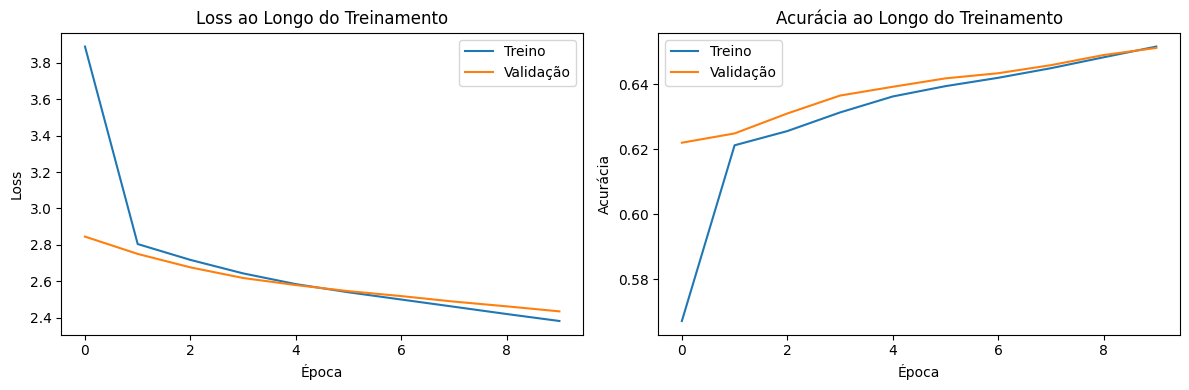

In [29]:
plt.figure(figsize=(12, 4))

# Plot da loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss ao Longo do Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Plot da acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia ao Longo do Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

# 🤖 Modelo 2: LSTM (Luong)


In [30]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LuongAttention, self).__init__(**kwargs)

    def call(self, inputs):
        """
        inputs: lista contendo [saídas_do_decoder, saídas_do_encoder]
          - decoder_outputs: tensor de shape (batch_size, tempo_decoder, LSTM_UNITS)
          - encoder_outputs: tensor de shape (batch_size, tempo_encoder, LSTM_UNITS)
        """
        decoder_outputs, encoder_outputs = inputs

        # Calcula os scores (pontuações) via produto escalar entre as saídas do decoder e do encoder
        # Resultado: (batch_size, tempo_decoder, tempo_encoder)
        scores = tf.matmul(decoder_outputs, encoder_outputs, transpose_b=True)

        # Aplica softmax para normalizar os scores em pesos de atenção
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Calcula o vetor de contexto como a soma ponderada das saídas do encoder
        # Resultado: (batch_size, tempo_decoder, LSTM_UNITS)
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        return context_vector

In [31]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model



def build_lstm_luong(vocab_size_pt, vocab_size_fr):

    # ----- Encoder -----
    # Entrada do encoder (texto em francês)
    encoder_inputs = Input(shape=(None,), name="entrada_encoder")
    # Camada de embedding que transforma índices em vetores densos
    encoder_embedding = Embedding(input_dim=vocab_size_fr,
                                  output_dim=EMBEDDING_DIM,
                                  name="embedding_encoder")(encoder_inputs)
    # Camada LSTM que retorna sequências (para a atenção) e os estados finais
    encoder_outputs, state_h, state_c = LSTM(LSTM_UNITS,
                                             return_state=True,
                                             return_sequences=True,
                                             name="lstm_encoder")(encoder_embedding)
    # Estados finais do encoder que serão usados para inicializar o decoder
    encoder_states = [state_h, state_c]

    # ----- Decoder -----
    # Entrada do decoder (texto em português com token de início)
    decoder_inputs = Input(shape=(None,), name="entrada_decoder")
    # Camada de embedding para o decoder
    decoder_embedding = Embedding(input_dim=vocab_size_pt,
                                  output_dim=EMBEDDING_DIM,
                                  name="embedding_decoder")(decoder_inputs)
    # Camada LSTM do decoder que retorna sequências; inicializa com os estados do encoder
    decoder_lstm_outputs, _, _ = LSTM(LSTM_UNITS,
                                      return_sequences=True,
                                      return_state=True,
                                      name="lstm_decoder")(decoder_embedding, initial_state=encoder_states)

    # ----- Atenção Luong -----
    # Calcula o vetor de contexto utilizando as saídas do encoder e do decoder
    context_vector = LuongAttention(name="attention")([decoder_lstm_outputs, encoder_outputs])
    # Concatena o vetor de contexto com as saídas do decoder para combinar as informações
    decoder_combined_context = Concatenate(axis=-1, name="concat_decoder")([decoder_lstm_outputs, context_vector])

    # ----- Camada de saída -----
    # Aplica uma camada densa (TimeDistributed) com softmax para gerar a probabilidade de cada token
    decoder_dense = TimeDistributed(Dense(vocab_size_pt, activation="softmax"), name="saida_final")
    decoder_outputs = decoder_dense(decoder_combined_context)

    # ----- Modelo final -----
    # O modelo recebe duas entradas: a sequência do encoder e a sequência do decoder.
    # E gera a sequência de saída (tradução em português).
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

In [32]:
lstm_luong_model = build_lstm_luong(vocab_size_pt, vocab_size_fr)
lstm_luong_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrando um resumo do modelo
lstm_luong_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ entrada_encoder           │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entrada_decoder           │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_encoder         │ (None, None, 256)      │      9,465,088 │ entrada_encoder[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_decoder         │ (None, None, 256)      │      9,603,840 │ entrada_decoder[0][0]  │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_encoder (LSTM)       │ [(None, None, 512),    │      1,574,912 │ embedding_encoder[0][… │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_decoder (LSTM)       │ [(None, None, 512),    │      1,574,912 │ embedding_decoder[0][… │
│                           │ (None, 512), (None,    │                │ lstm_encoder[0][1],    │
│                           │ 512)]                  │                │ lstm_encoder[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ (None, None, 512)      │              0 │ lstm_decoder[0][0],    │
│ (LuongAttention)          │                        │                │ lstm_encoder[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_decoder            │ (None, None, 1024)     │              0 │ lstm_decoder[0][0],    │
│ (Concatenate)             │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ saida_final               │ (None, None, 37515)    │     38,452,875 │ concat_decoder[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 60,671,627 (231.44 MB)

 Trainable params: 60,671,627 (231.44 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = lstm_luong_model.fit(
    [X_train, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 47s 68ms/step - accuracy: 0.5701 - loss: 3.6519 - val_accuracy: 0.6501 - val_loss: 2.4456
Epoch 2/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.6515 - loss: 2.3698 - val_accuracy: 0.6642 - val_loss: 2.2647
Epoch 3/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.6711 - loss: 2.1141 - val_accuracy: 0.6956 - val_loss: 2.0537
Epoch 4/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.7142 - loss: 1.7489 - val_accuracy: 0.7265 - val_loss: 1.8446
Epoch 5/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.7522 - loss: 1.3958 - val_accuracy: 0.7432 - val_loss: 1.7364
Epoch 6/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.7913 - loss: 1.0933 - val_accuracy: 0.7498 - val_loss: 1.6958
Epoch 7/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - accuracy: 0.8292 - loss: 0.8608 - val_accuracy: 0.7525 - val_loss: 1.6909
Epoch 8/10
549/549 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.8554 - loss: 0.7019 - 

# 📊 Avaliação Detalhada do Modelo LSTM

In [34]:
# 1. Distribuição das Previsões Corretas vs Incorretas por Posição na Sequência
def plot_accuracy_by_position(model, X_val, y_val, max_length=40):
    # Fazendo previsões
    predictions = model.predict([X_val, y_val[:, :-1]])
    predictions_classes = np.argmax(predictions, axis=-1)

    # Calculando acurácia por posição
    correct_by_position = []
    for pos in range(predictions.shape[1]):
        correct = np.sum(predictions_classes[:, pos] == y_val[:, pos+1])
        correct_by_position.append(correct / len(y_val))

    plt.figure(figsize=(12, 6))
    plt.plot(correct_by_position)
    plt.title('Acurácia por Posição na Sequência')
    plt.xlabel('Posição na Sequência')
    plt.ylabel('Acurácia')
    plt.grid(True)
    plt.show()

# 2. Distribuição do Comprimento das Traduções
def plot_length_distribution(y_true, y_pred):
    # Calculando comprimentos (ignorando padding)
    true_lengths = [len([x for x in seq if x != 0]) for seq in y_true]
    pred_lengths = [len([x for x in seq if x != 0]) for seq in y_pred]

    plt.figure(figsize=(12, 6))
    plt.hist([true_lengths, pred_lengths], label=['Real', 'Previsto'],
             alpha=0.7, bins=20)
    plt.title('Distribuição do Comprimento das Traduções')
    plt.xlabel('Comprimento da Sequência')
    plt.ylabel('Frequência')
    plt.legend()
    plt.show()

# 3, Heatmap das Palavras Mais Frequentemente Confundidas
def plot_confusion_heatmap(y_true, y_pred, tokenizer, top_k=20):
    # Pegando as palavras mais frequentes
    most_common = {v: k for k, v in tokenizer.word_index.items()}
    most_common = {i: most_common[i] for i in range(1, top_k+1)}

    # Criando matriz de confusão para as palavras mais comuns
    conf_matrix = confusion_matrix(
        y_true.flatten(),
        y_pred.flatten(),
        labels=list(range(1, top_k+1))
    )

    # Normalizando
    conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(15, 12))
    sns.heatmap(conf_matrix,
                xticklabels=list(most_common.values()),
                yticklabels=list(most_common.values()),
                annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Heatmap de Confusão para as Palavras Mais Frequentes')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Gerando as visualizações

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step


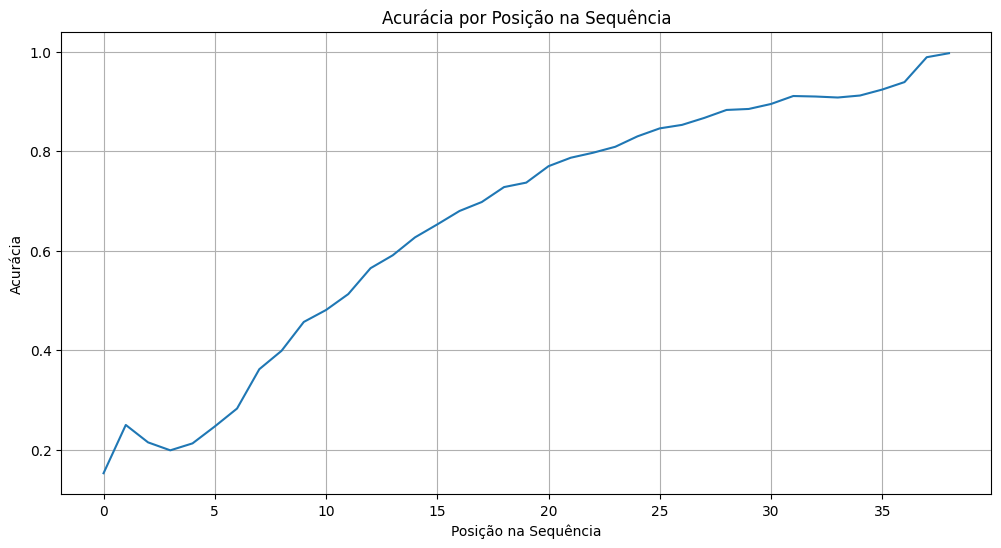

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


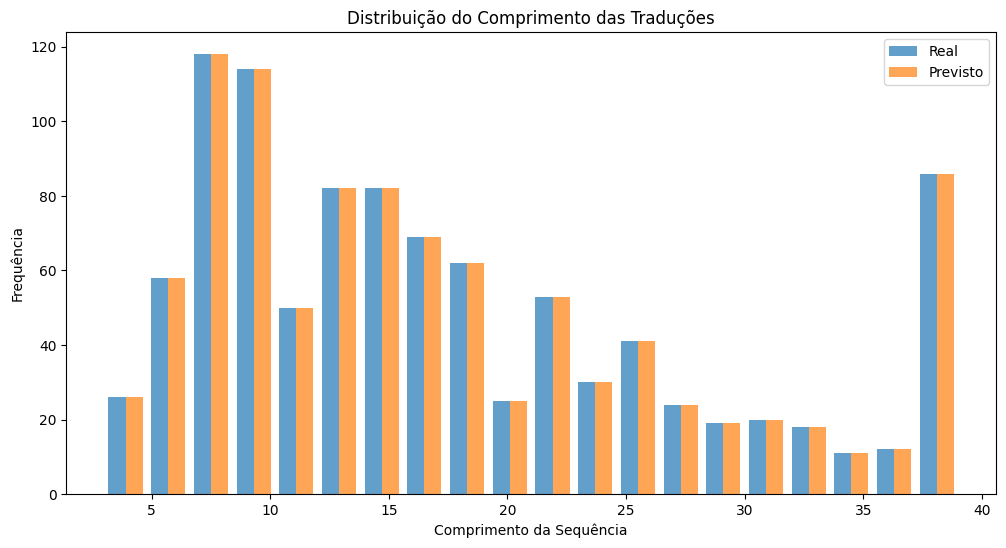

<ipython-input-34-5a6ddc1bd591>:50: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)


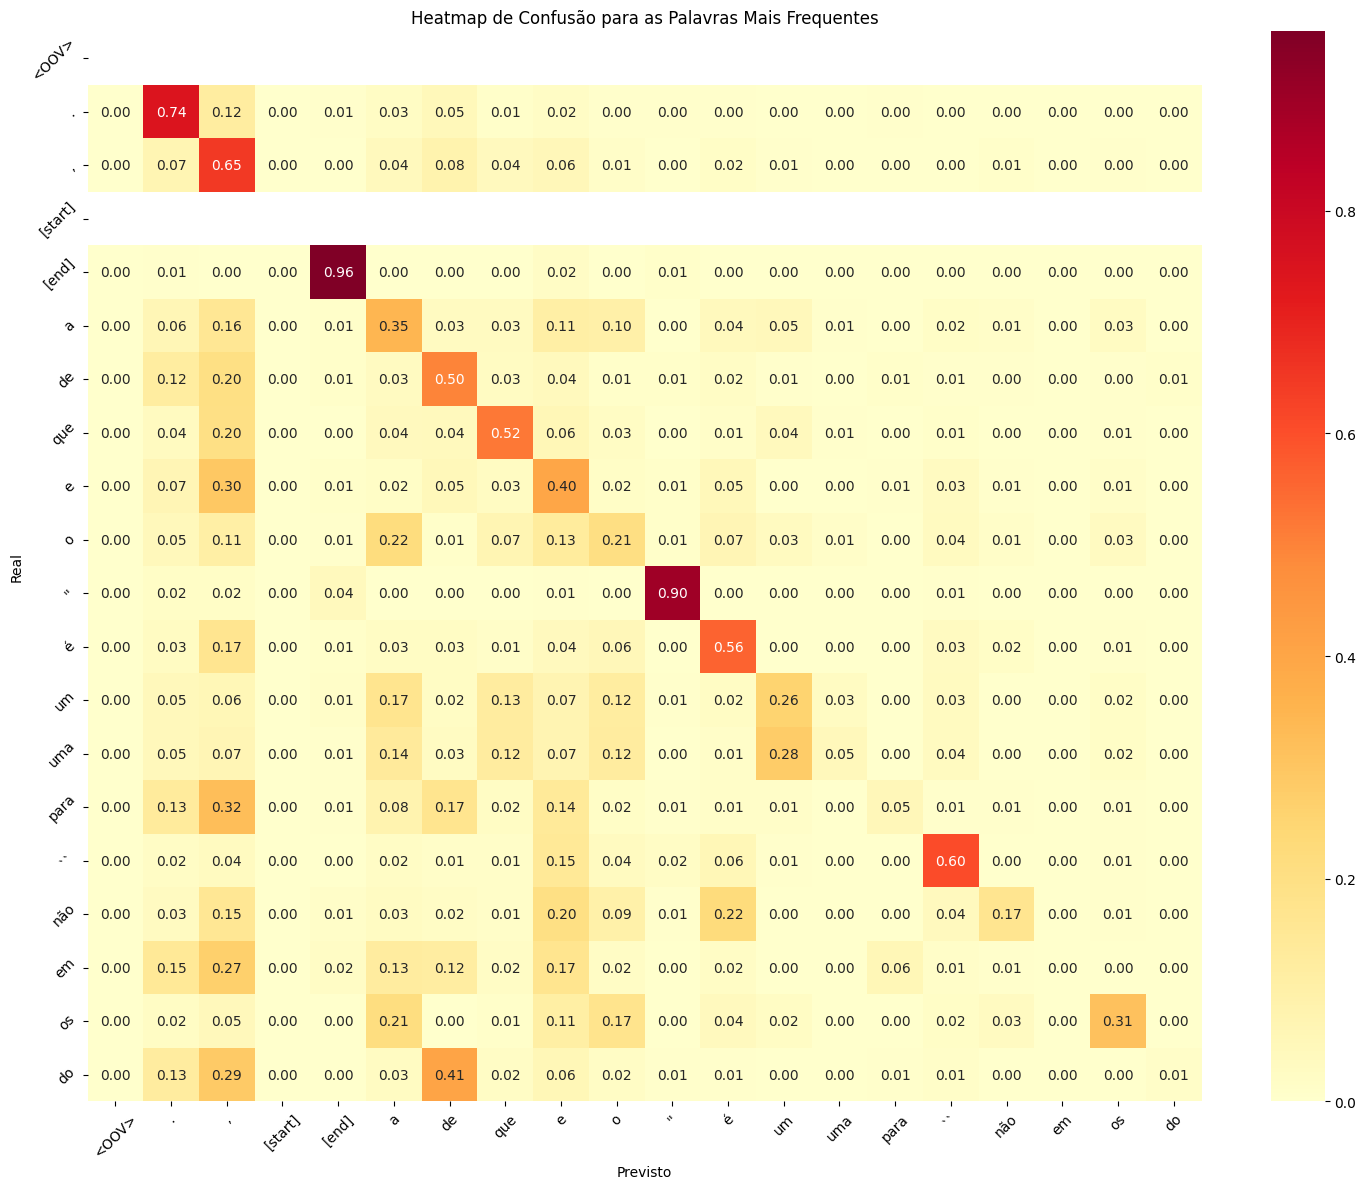


Legenda das visualizações:
1. Gráfico de Acurácia por Posição: Mostra como o modelo se comporta em diferentes posições da sequência
2. Distribuição de Comprimentos: Compara o tamanho das traduções reais vs. previstas
3. Heatmap: Mostra quais palavras frequentes são mais confundidas entre si


In [35]:
# 1. Acurácia por posição
val_data = [X_train[-1000:], y_train[-1000:]]  # Usando últimas 1000 amostras como validação
plot_accuracy_by_position(model, val_data[0], val_data[1])

# 2. Distribuição de comprimentos
predictions = model.predict([val_data[0], val_data[1][:, :-1]])
pred_classes = np.argmax(predictions, axis=-1)
plot_length_distribution(val_data[1][:, 1:], pred_classes)

# 3. Heatmap de confusão
plot_confusion_heatmap(val_data[1][:, 1:], pred_classes, tokenizer_pt)

print("\nLegenda das visualizações:")
print("1. Gráfico de Acurácia por Posição: Mostra como o modelo se comporta em diferentes posições da sequência")
print("2. Distribuição de Comprimentos: Compara o tamanho das traduções reais vs. previstas")
print("3. Heatmap: Mostra quais palavras frequentes são mais confundidas entre si")